# Data Augmentation. Multi-Layer Perceptron - MNIST Dataset.

In the previous notebook we found that using a **Multi-Layer Perceptron** we can obtain a high *accuracy* in the classification of images from the **MNIST** dataset of handwritten numbers. But this *accuracy* can be reduced when this model classifies images which have disturbances in his data, such as **translations**, **rotations** and **noise**, so the model would no longer be so robust. Using the **Multi-Layer Perceptron** code implemented in **Keras** from the previous notebook, we are going to check how the model behaves when the images that it attempts to classify may not be centered, or not correctly aligned, or have poor image quality:

In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.layers     import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# We load the dataset from the file with pandas
mnist = pd.read_csv("./sample_data/mnist_train_small.csv", header=None).as_matrix()

# X: sample attributes(20000x784), Y: sample labels (20000x1)
X, Y = mnist[:, 1:], mnist[:, 0:1]

Xt = X / 255  # Scale the data matrix (20000x744)
Yt = to_categorical(Y, 10)  # One-hot encoding: [1,0,0,...,0], [0,1,0,...,0], ..., [0,0,...,0,1]

X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yt, train_size=0.7, test_size=0.3)  # Partitioning in training and test data

mlp = tf.keras.Sequential()

mlp.add(Dense(128, activation='relu'))
mlp.add(Dropout(0.4))  # Dropot as regularization technique to prevent overfitting
mlp.add(Dense(64, activation='relu'))  # Hidden layer
mlp.add(Dropout(0.4))
mlp.add(Dense(32, activation='relu'))  # Hidden layer
mlp.add(Dropout(0.4))
mlp.add(Dense(10, activation='softmax'))  # Output layer, activation function: Softmax, essential in deep learning classifiers


mlp.compile(loss='categorical_crossentropy',  # loss function to predict categorical labels
              optimizer=tf.keras.optimizers.Adam(),  # Combines the advantages of two SGD algorithms: AdaGrad and RMSProp
              metrics=['acc'])

# We save in mlp_info, as it provides useful information for plotting loss and accuracy in training and validation
mlp_info = mlp.fit(X_train, Y_train,
          batch_size=32,
          epochs=50,  # Little epoch for demonstration purposes only
          verbose=0,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
          validation_data=(X_test, Y_test))  # In addition to train data metrics, display validation data metrics

This time, the model has has been more thoughtfully trained and reached achieved **97%** of  **validation accuracy**, as can be appreciated in the following plots:

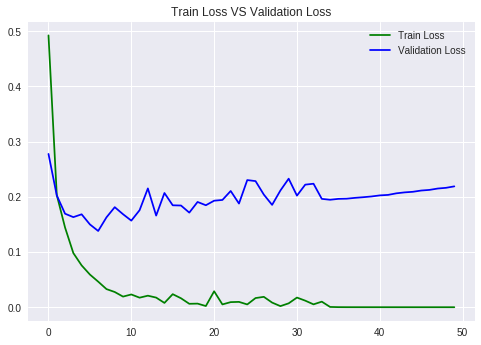

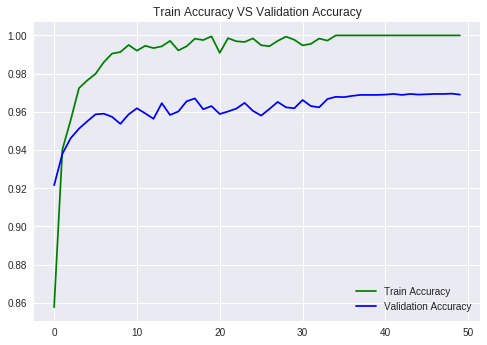

In [271]:
plt.title("Train Loss VS Validation Loss")
plt.plot(mlp_info.history['loss'],     c='g')
plt.plot(mlp_info.history['val_loss'], c='b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

plt.title("Train Accuracy VS Validation Accuracy")
plt.plot(mlp_info.history['acc'],     c='g')
plt.plot(mlp_info.history['val_acc'], c='b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

We are going to generate 4 different test sets that include the distortions mentioned above (**translation**, **rotation**, **25% of noise** and **50% of noise**). To do this, we are going to develop some functions that are responsible for distorting the images:

In [0]:
def translation(X):  # Image set translation
  
  resul = np.zeros(X.shape)  # numpy array of 0s that serves as template
  
  for i, elem in enumerate(X):  # for each sample
    
    img = elem.reshape(28, 28)  # Make array of pixels look like a matrix
    xmov = np.random.randint(14) - 7  # Random translation coef. in x
    ymov = np.random.randint(14) - 7  # Random translation coef. in y
    resul[i] = sc.ndimage.shift(img, (xmov, ymov)).flatten()  # Apply the translation and flatten into a (784, 1)
    
  return resul


def rotation(X):  # Image set rotation
  
  resul = np.zeros(X.shape)
  
  for i, elem in enumerate(X):
    
    img = elem.reshape(28, 28)
    rot_ang = np.random.randint(180) - 90  # Random rotation coef.
    resul[i] = sc.ndimage.rotate(img, rot_ang, reshape=False).flatten()  # Apply the rotation angle and flatten into a (784, 1)
    
  return resul


def noise(X, p):  # Image set noising, with p: percentage of noise
  
  resul = np.zeros(X.shape)
  
  for i, elem in enumerate(X):
    
    img = elem.reshape(28, 28)
    noise = np.random.uniform(low=-p, high=p, size=(28, 28))  # Create noise mask 28x28 matrix with values in [-p, p)
    resul[i] = np.clip(img + noise, 0.0, 1.0).flatten()  # Sum the noise and, due to data is scaled, clipping between 0 and 1 is needed
    
  return resul

For each type of distortion implemented, a different test set is created to evaluate the Multi-Layer Perceptron model. The figures below represent the effect of each distortion on the original image:

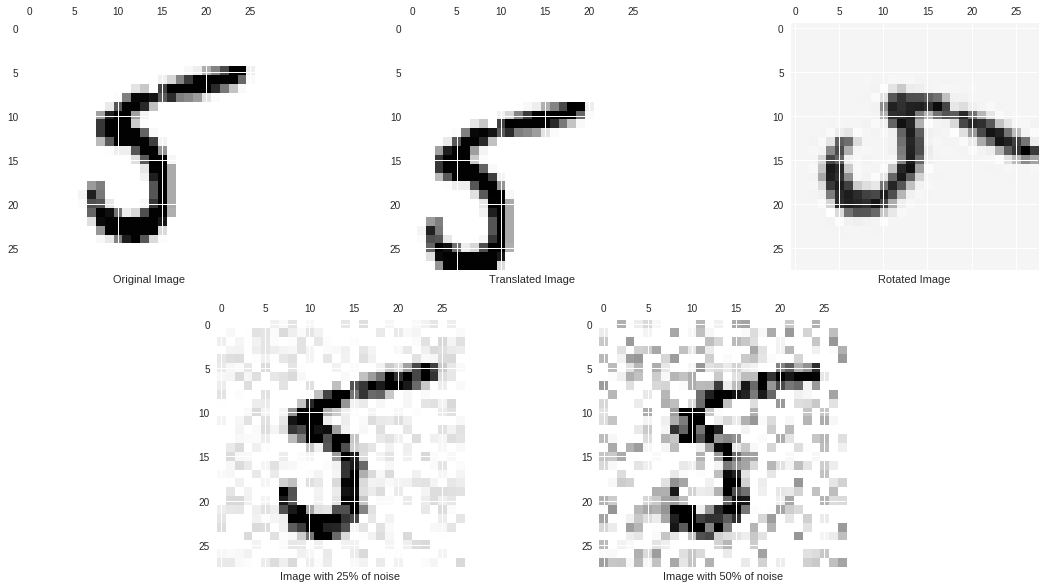

In [303]:
transX_test = translation(X_test)  # Create 4 new and different test sets, one for each distortion applied
rotX_test = rotation(X_test)
noi25X_test = noise(X_test, 0.25)
noi50X_test = noise(X_test, 0.5)

item = 6  # index of the image displayed

fig = plt.figure(figsize=(20,10))  # The figure will include with 5 subfigures:

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)  # Shape and location
ax1.matshow(X_test[item,:].reshape(28, 28))  # Reshaping (784,1) for fitting it to 28x28
plt.xlabel("Original Image")

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax2.matshow(transX_test[item,:].reshape(28, 28))
plt.xlabel("Translated Image")

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax3.matshow(rotX_test[item,:].reshape(28, 28))
plt.xlabel("Rotated Image")

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax4.matshow(noi25X_test[item,:].reshape(28, 28))
plt.xlabel("Image with 25% of noise")

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax5.matshow(noi50X_test[item,:].reshape(28, 28))
plt.xlabel("Image with 50% of noise")
plt.show()

In [294]:
  # Save metrics about the model for each type of test data

score_orig = mlp.evaluate(X_test, Y_test, verbose=0)
score_trans = mlp.evaluate(transX_test, Y_test, verbose=0)
score_rot = mlp.evaluate(rotX_test, Y_test, verbose=0)
score_noi25 = mlp.evaluate(noi25X_test, Y_test, verbose=0)
score_noi50 = mlp.evaluate(noi50X_test, Y_test, verbose=0)

print("Accuracy achieved with original images: ", score_orig[1] * 100,"%")  # Print accuracy, set in scores obtained
print("Accuracy achieved with translated images: ", score_trans[1] * 100,"%")
print("Accuracy achieved with rotated images: ", score_rot[1] * 100,"%")
print("Accuracy achieved with images + 25% of noise: ", score_noi25[1] * 100,"%")
print("Accuracy achieved with images + 50% of noise: ", score_noi50[1] * 100,"%")

Accuracy achieved with original images:  96.89999999999999 %
Accuracy achieved with translated images:  24.05 %
Accuracy achieved with rotated images:  48.05 %
Accuracy achieved with images + 25% of noise:  93.51666666666667 %
Accuracy achieved with images + 50% of noise:  72.61666666666666 %


As we can see, when evaluating the same model with the 5 different sets of test data, it only classifies with a high accuracy the images of the original dataset. For the distorted datasets, the model does not perform so well, which is understandable, since the model has not been trained with these distorted data. If the model were trained with a dataset that combines both the original images and the possible distortions considered, a much better accuracy would be obtained. But remember that Multi-Layer Perceptron is not the appropriate architecture for the classification of images, a subject that we will discuss in the following notebook.